In [3]:
import numpy as np
#import numba as nb
#import healpy as hp
import re
#import pandas as pd
#import pymaster as nmt
#from scipy import fftpack
#from scipy.optimize import newton, least_squares
#from scipy.interpolate import interp1d
#from scipy.integrate import quad
#from scipy.ndimage import gaussian_filter as gf
#from scipy.stats import rv_histogram, norm
#from scipy.stats import chi2
from astropy.io import fits
#from astropy.coordinates import SkyCoord
#from astropy.coordinates import match_coordinates_sky
#from astropy import units as u
#from tqdm import tqdm
#import os
#import sys
#from time import time
import subprocess
#import emcee
#import corner
#from multiprocessing import Pool, set_start_method
#import multiprocessing as mp
#import dynesty
#from dynesty import plotting as dyplot
#from dynesty.pool import Pool
#import nautilus
#import gc
#import itertools
#from IPython.display import display, Math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
import os
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.autolayout': True})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
plot_dir = f'/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/plots/'
if not os.path.isdir(plot_dir):
    os.mkdir(plot_dir)

## $\underline{ \rm Cosmo ~parameters ~and ~observational ~setup}$

### Cosmocov config file

In [5]:
template_ini_cov = """
#
# Cosmological parameters
#
Omega_m : {Om}
Omega_v : {Ov}
sigma_8 : {sig8}
n_spec : {ns}
w0 : -1.0
wa : 0.0
omb : {ob}
h0 : {h}
#
# Survey and galaxy parameters
#
# area in degrees
area : {area}
# c_footprint_file : /data/aguinot/library/CosmoCov/covs/ini_files/w_lrg_w3_rand_mask.txt
sourcephotoz : multihisto
lensphotoz : multihisto
source_tomobins : {source_nbins}
lens_tomobins : {lens_nbins}
sigma_e : {sig_e}
shear_REDSHIFT_FILE : {source_nz_path}
clustering_REDSHIFT_FILE : {lens_nz_path}
# n_gal,lens_n_gal in gals/arcmin^2
source_n_gal : {gal_density}
lens_n_gal : {gal_density}
lens_tomogbias : 2.
lens_tomo_bmag : 0.0
# IA parameters
IA : 0
A_ia : {a_ia}
eta_ia : 0.0
#
# Covariance paramters
#
# tmin,tmax in arcminutes
tmin : {theta_min}
tmax : {theta_max}
ntheta : {theta_N}
ng : {do_ng}
cng : {do_ng}
outdir : {out_dir_path}
filename : {out_file_name}
ss : true
ls : false
ll : false
"""

### Parameters

In [6]:
# Planck cosmo 2018 | TT,TE,EE+lowE+lensing+BAO
h = 0.6898
Om = 0.2905
Ov = 0.7095
sig8 = 0.8260
ns = 0.9690
#Ob_h2 = 0.02242
Ob = 0.0473
#Oc_h2 = 0.11933
#Oc = Oc_h2/h**2
b_ia = 0.5
B_amp = 3.13

#  angular scales
theta_min = 1
theta_max = 200
theta_N = 20
#bin_size = 0.3
#nbins = int((np.log(theta_max) - np.log(theta_min))/bin_size)
#print(nbins)

#  include non gaussian contribution 0/1
do_ng = 0

area = 1000
shape_noise = 0.4
n_gal_eff = 2.6,2.6,2.6,2.6,2.6,2.6,2.6,2.6,2.6,2.6

# source and lens n(z) w/o tomography
source_nbins = 5
lens_nbins = 2
nz_path = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/'
#source_nz_path = nz_path+'source_test.nz'
source_nz_path = nz_path+'source_lssty1.nz'
#source_nz_path = nz_path+'source_LSST_10bins.dat'
lens_nz_path = nz_path+'lens_test.nz'
#lens_nz_path = nz_path+'lens_lssty1.nz'


ini_dir = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/ini_files/'

### Create parameters dictionnary

In [7]:
cosmo_dict = {
    "Om": Om,
    "Ov": Ov,
    "sig8": sig8,
    "ns": ns,
    "ob": Ob,
    "h": h,
#    "oc": Oc,
    "a_ia": b_ia,
}

survey_dict = {
    "area": area,
    "shape_noise": shape_noise*np.sqrt(2),
    "source_tomobins": source_nbins,
    "lens_tomobins": lens_nbins,
    "source_nz_path": source_nz_path,
    "lens_nz_path": lens_nz_path,
    "gal_density": n_gal_eff,
}

In [8]:
config_file = template_ini_cov.format(
        Om=cosmo_dict["Om"],
        Ov=cosmo_dict["Ov"],
        sig8=cosmo_dict["sig8"],
        ns=cosmo_dict["ns"],
        ob=cosmo_dict["ob"],
        h=cosmo_dict["h"],
        a_ia=cosmo_dict["a_ia"],

        area=survey_dict["area"],
        source_nbins = survey_dict["source_tomobins"],
        lens_nbins = survey_dict["lens_tomobins"],
        sig_e=survey_dict["shape_noise"],
        lens_tomobins = survey_dict["lens_tomobins"],
        source_nz_path=survey_dict["source_nz_path"],
        lens_nz_path=survey_dict["lens_nz_path"],
        gal_density=','.join(map(str, survey_dict["gal_density"])),
    
        theta_min=theta_min,
        theta_max=theta_max,
        theta_N=theta_N,
        out_dir_path=plot_dir,
        out_file_name="cov_tmp",
        do_ng=int(do_ng),
    )

config_path = ini_dir + 'cov_ludo.ini'
with open(config_path, 'w') as f:
    f.write(config_file)

In [9]:
#config_file.split('\n')
config_path

'/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/ini_files/cov_ludo.ini'

In [10]:
tomo_nbins = source_nbins*(source_nbins+1)
n_entries = tomo_nbins*theta_N
n_blocks = str(int(tomo_nbins*(tomo_nbins+1)/2))
print('number of distinct tomographic bins combination: ',int(tomo_nbins/2))
print('number of covariance matrix entries: ','2x'+str(int(tomo_nbins/2))+'x'+str(theta_N)+'=',n_entries)
print('number of cosmocov blocks: ',n_blocks)
print('cosmocov config path: ',config_path)

number of distinct tomographic bins combination:  15
number of covariance matrix entries:  2x15x20= 600
number of cosmocov blocks:  465
cosmocov config path:  /Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/ini_files/cov_ludo.ini


## $\underline{\rm COVARIANCE ~MATRIX ~CALCULATION}$

In [11]:
cmd1 = "echo {1.."+n_blocks+"} | xargs -n 1 -P 12 -I{} ./cov {} "+config_path
result1 = subprocess.check_output(cmd1, shell=True, text=True)
#result1.split('\n')

In [12]:
cmd2 = f'f="cov_ludo"; cat plots/cov_tmp*  > $f'#; python plot.py $f'
result2 = subprocess.check_output(cmd2, shell=True, text=True)

In [13]:
def get_cov(path):

    data = np.genfromtxt(path)
    ndata = int(np.max(data[:,0]))+1

    # print("Dimension of cov: %dx%d"%(ndata,ndata))

    ndata_min = int(np.min(data[:,0]))
    cov_g = np.zeros((ndata,ndata))
    cov_ng = np.zeros((ndata,ndata))
    for i in range(0,data.shape[0]):
        cov_g[int(data[i,0]),int(data[i,1])] =data[i,8]
        cov_g[int(data[i,1]),int(data[i,0])] =data[i,8]
        cov_ng[int(data[i,0]),int(data[i,1])] =data[i,9]
        cov_ng[int(data[i,1]),int(data[i,0])] =data[i,9]

    return cov_g, cov_ng, cov_g+cov_ng

In [14]:
data = np.genfromtxt('cov_ludo')
data.shape,int(np.max(data[:,0]))+1

((186000, 10), 600)

### Plot Covariance matrix

In [15]:
cov_g, cov_ng, cov_tot = get_cov('cov_ludo')

(600, 600)

/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


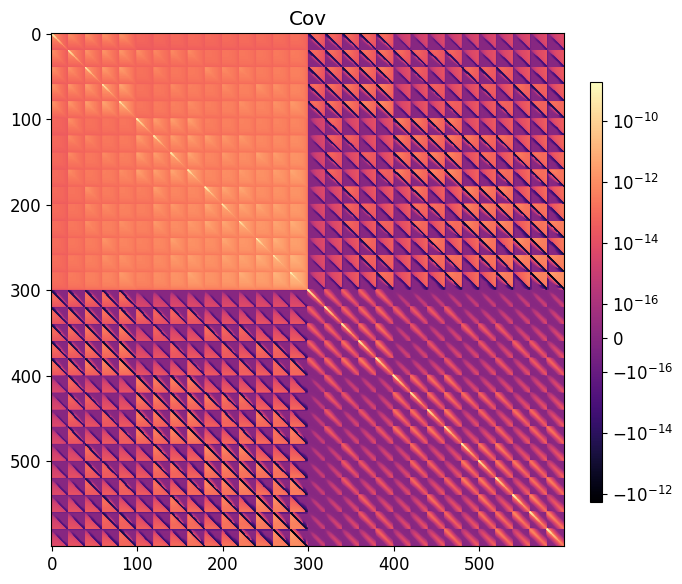

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6,6))

im = axs.imshow(cov_tot,cmap='magma',norm=matplotlib.colors.SymLogNorm(1e-16))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)
cov_tot.shape

### Save covariance matrix in CCL ordering

In [15]:
# Create a PrimaryHDU object
hdu = fits.PrimaryHDU(cov_tot.astype(np.float64))
# Create an HDU list and append the PrimaryHDU
hdul = fits.HDUList([hdu])
# Specify the FITS filename
fits_filename = "covariance_cosmocov_20theta.fits"
# Write the HDU list to the FITS file
hdul.writeto(fits_filename, overwrite=True)

### Calculte covariance matrix in BNT ordering

# c'est la le boulot a faire!

### Plot correlation matrix in CCL ordering

In [16]:
ndata = n_entries
pp_norm = np.zeros((ndata,ndata))
for i in range(ndata):
    for j in range(ndata):
        pp_norm[i,j] = cov_tot[i,j]/ np.sqrt(cov_tot[i,i]*cov_tot[j,j])

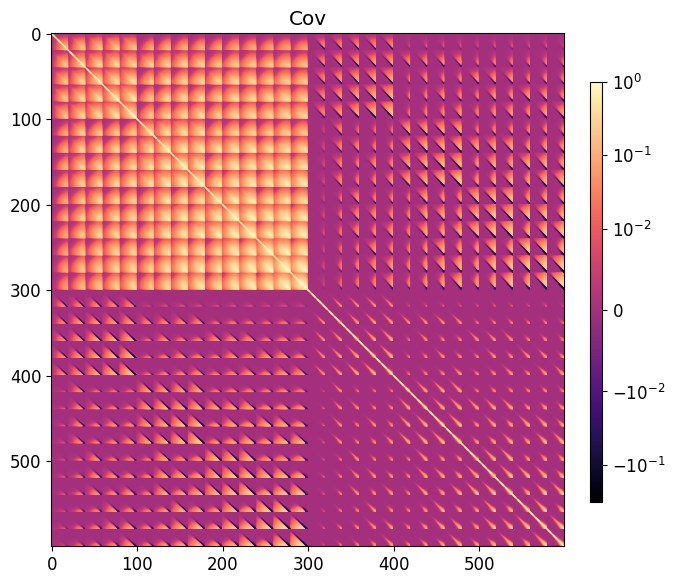

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6,6))

im = axs.imshow(pp_norm,cmap='magma',norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

## $\rm \underline{DATA ~VECTOR ~CALCULATION}$

In [18]:
import pyccl

In [19]:
def get_theta_bins(theta_min,theta_max,theta_N):
    bin_edges = np.logspace(np.log10(theta_min), np.log10(theta_max), theta_N+1)
    theta_center_arcmin = 2./3 * (bin_edges[1:]**3. - bin_edges[:-1]**3.)/(bin_edges[1:]**2. - bin_edges[:-1]**2.)
    theta_center_deg = theta_center_arcmin/60.
    theta_center_rad = np.deg2rad(theta_center_deg)
    bin_edges_deg = bin_edges/60.
    bin_edges_rad = np.deg2rad(bin_edges_deg)
    return theta_center_deg,bin_edges_deg

### Setup the model vectors

In [20]:
V_I_CCL_order = np.zeros(n_entries)
V_I_BNT_order = np.zeros(n_entries)

### Set up the $\ell$ space and $\theta$ space using cosmocov settings

In [21]:
ell_min = 5
ell_max = 5e5
n_ell = 2000

ell_arr = np.geomspace(ell_min,ell_max,n_ell)
#ell_arr = np.logspace(0, np.log10(10000), 1000)

theta_arr,theta_edges = get_theta_bins(theta_min,theta_max,theta_N)
theta_arcmin_arr = theta_arr*60

In [22]:
theta_arr,theta_edges

(array([0.0193053 , 0.02516101, 0.03279288, 0.04273966, 0.05570351,
        0.07259957, 0.09462057, 0.123321  , 0.16072689, 0.20947879,
        0.27301817, 0.3558304 , 0.46376135, 0.60443005, 0.78776657,
        1.02671297, 1.3381369 , 1.74402236, 2.27302152, 2.96247741]),
 array([0.01666667, 0.02172202, 0.02831077, 0.03689804, 0.04809   ,
        0.06267672, 0.0816879 , 0.10646559, 0.13875887, 0.18084739,
        0.23570226, 0.30719578, 0.40037481, 0.52181703, 0.68009526,
        0.88638265, 1.15524141, 1.50565075, 1.96234673, 2.55756833,
        3.33333333]))

### Set up the pyccl cosmology to the cosmocov cosmology

In [25]:
#cosmo_dict

In [26]:
# define the cosmology object in ccl, used halofit as default
cosmo = pyccl.Cosmology(Omega_c = cosmo_dict['Om']-cosmo_dict['ob'], Omega_b = cosmo_dict['ob'],sigma8 = cosmo_dict['sig8'], n_s = cosmo_dict['ns'], h = cosmo_dict['h'])
cosmo

<pyccl.cosmology.Cosmology>
	Neff    = 3.044
	Omega_b = 0.0473
	Omega_c = 0.24319999999999997
	h       = 0.6898
	n_s     = 0.969
	sigma8  = 0.826
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0x15fa93e6a8c912e3

### Read all n(z) in one file and set up the n(z) tracers for pyccl

source redshift distributions:  /Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_lssty1.nz


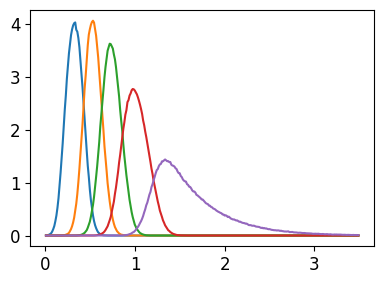

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

print("source redshift distributions: ",source_nz_path)
file_data = np.loadtxt(source_nz_path)
nzrows = file_data.shape[0]
ntomobin = file_data.shape[1]-1

nz_table = np.zeros((nzrows,ntomobin+1))
nz_tracers = []
A_IA = 0

for i in range(ntomobin):
    nz_table[:,0] = file_data[:,0]
    nz_table[:,i+1] = file_data[:,i+1]
    
    #n_of_z_interp = interp1d(nz_table[:,0], nz_table[:,i+1], kind='quadratic',fill_value='extrapolate')
    
    nz_tracers.append(pyccl.WeakLensingTracer(cosmo,dndz=(nz_table[:,0],nz_table[:,i+1]),
                                ia_bias=(nz_table[:,0],A_IA*np.ones_like(nz_table[:,0]))))
    
    plt.plot(nz_table[:,0],nz_table[:,i+1])

### Calculate and plot $C_\ell$ for all tomographic combinations

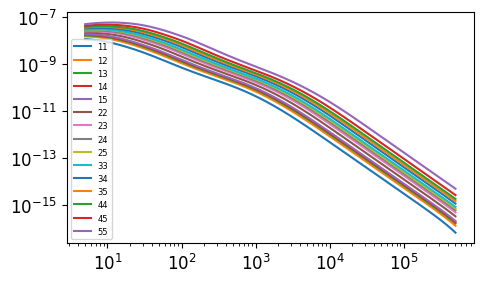

In [28]:
fig, axs = plt.subplots(1,1, figsize=(5, 3))

icpt = 0
Cell_arr = []

for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        Cell_arr.append(pyccl.angular_cl(cosmo,nz_tracers[iz-1],nz_tracers[jz-1],ell_arr))
        plt.loglog(ell_arr,Cell_arr[icpt],label=str(iz)+str(jz))
        icpt += 1

plt.yscale('log')
plt.yscale('log')
plt.legend(fontsize=6)

### Calculate and plot $\xi_+(\theta)$ and $\xi_-(\theta)$ for all tomographic combinations

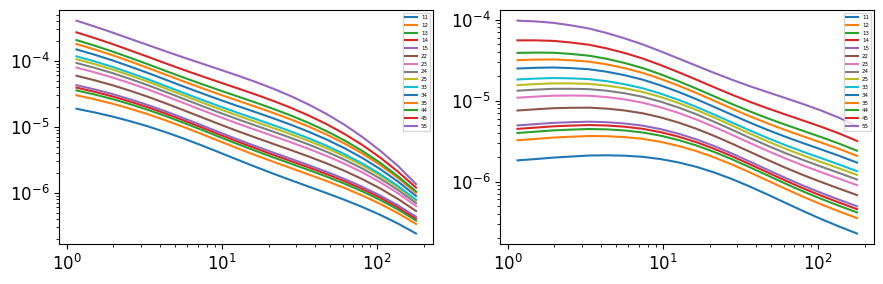

In [29]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

icpt_vector = 0

icpt = 0
xi_p = []

for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        xi_p.append(pyccl.correlation(cosmo,ell=ell_arr,C_ell=Cell_arr[icpt],theta=theta_arr,type='GG+',method='Bessel'))
        axs[0].semilogx(theta_arcmin_arr,xi_p[icpt],label=str(iz)+str(jz))
        V_I_CCL_order[icpt_vector:icpt_vector+theta_N] = xi_p[icpt]
        icpt += 1
        icpt_vector += theta_N

icpt = 0
xi_m = []

for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        xi_m.append(pyccl.correlation(cosmo,ell=ell_arr,C_ell=Cell_arr[icpt],theta=theta_arr,type='GG-',method='Bessel'))
        axs[1].semilogx(theta_arcmin_arr,xi_m[icpt],label=str(iz)+str(jz))
        V_I_CCL_order[icpt_vector:icpt_vector+theta_N] = xi_m[icpt]
        icpt += 1
        icpt_vector += theta_N


axs[0].set_yscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize=4)
axs[1].set_yscale('log')
axs[1].set_yscale('log')
axs[1].legend(fontsize=4)


In [30]:
icpt_vector = 0

for itheta,theta_val in enumerate(theta_arr):
    #print(itheta,theta_val)
    icpt = 0
    for iz in range(1,ntomobin+1):
        for jz in range(iz,ntomobin+1):
            V_I_BNT_order[icpt_vector] = xi_p[icpt][itheta]
            V_I_BNT_order[icpt_vector+int(n_entries/2)] = xi_m[icpt][itheta]
            icpt += 1
            icpt_vector += 1

Text(0, 0.5, '$V_A$')

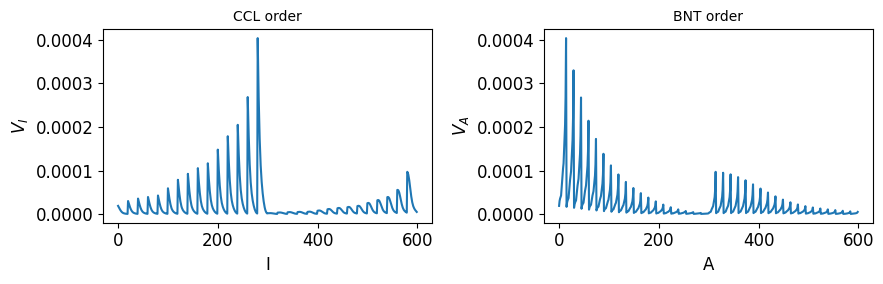

In [31]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(V_I_CCL_order)
axs[0].set_title('CCL order',fontsize=10)
axs[0].set_xlabel('I')
axs[0].set_ylabel('$V_I$')
axs[1].plot(V_I_BNT_order)
axs[1].set_title('BNT order',fontsize=10)
axs[1].set_xlabel('A')
axs[1].set_ylabel('$V_A$')

In [32]:
file_CCL_vector = 'data_vector_CCL_20theta.npy'
np.save(file_CCL_vector,V_I_CCL_order)

file_BNT_vector = 'data_vector_BNT_20theta.npy'
np.save(file_BNT_vector,V_I_BNT_order)

In [49]:
V_I_test_BNT_order = np.zeros(n_entries)

icpt = 0
for itheta in range(theta_N):
    for itomo in range(int(tomo_nbins/2)):
        iindex = itomo*theta_N+itheta
        V_I_test_BNT_order[icpt] = V_I_CCL_order[iindex]
        ishift = int(n_entries/2)
        V_I_test_BNT_order[icpt+ishift] = V_I_CCL_order[iindex+ishift]
        #print(icpt,itheta,itomo,iindex)
        icpt += 1

Text(0, 0.5, '$V_A$')

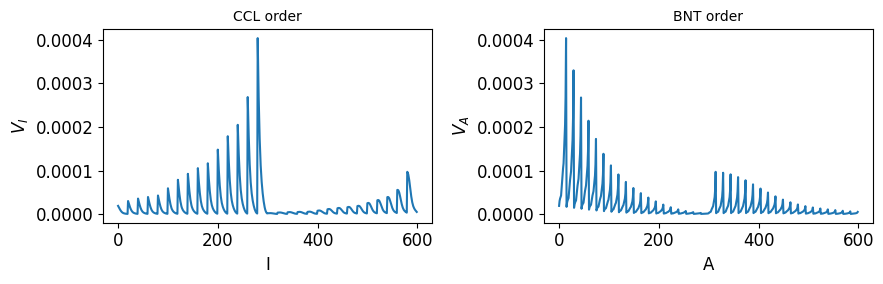

In [50]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(V_I_CCL_order)
axs[0].set_title('CCL order',fontsize=10)
axs[0].set_xlabel('I')
axs[0].set_ylabel('$V_I$')
axs[1].plot(V_I_test_BNT_order)
axs[1].set_title('BNT order',fontsize=10)
axs[1].set_xlabel('A')
axs[1].set_ylabel('$V_A$')

In [52]:
cov_tot.shape

(600, 600)

In [58]:
cov_tot_BNT_order = np.zeros((n_entries,n_entries))

icpt = 0
for itheta in range(theta_N):
    for itomo in range(int(tomo_nbins/2)):
        iindex = itomo*theta_N+itheta
        cov_tot_BNT_order[:,icpt] = cov_tot[:,iindex]
        ishift = int(n_entries/2)
        cov_tot_BNT_order[:,icpt+ishift] = cov_tot[:,iindex+ishift]
        icpt += 1
        
icpt = 0
for itheta in range(theta_N):
    for itomo in range(int(tomo_nbins/2)):
        iindex = itomo*theta_N+itheta
        cov_tot_BNT_order[icpt,:] = cov_tot_BNT_order[iindex,:]
        ishift = int(n_entries/2)
        cov_tot_BNT_order[icpt+ishift,:] = cov_tot_BNT_order[iindex+ishift,:]
        icpt += 1

(600, 600)

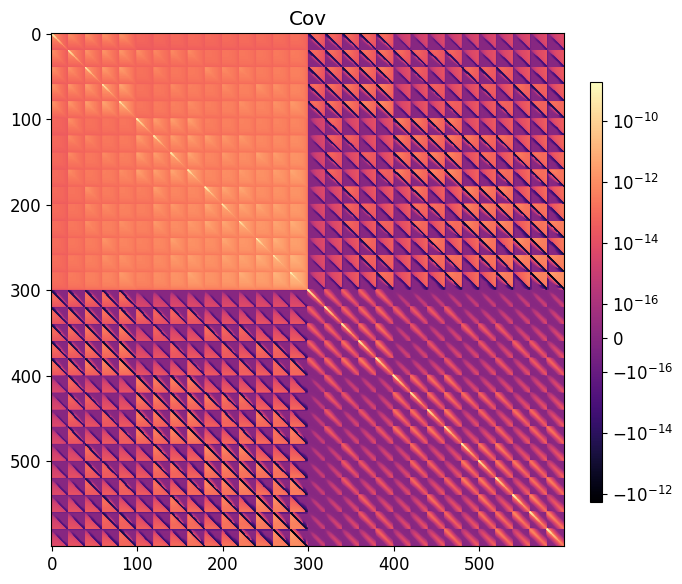

In [59]:
fig, axs = plt.subplots(1, 1, figsize=(6,6))

im = axs.imshow(cov_tot,cmap='magma',norm=matplotlib.colors.SymLogNorm(1e-16))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)
cov_tot.shape

(600, 600)

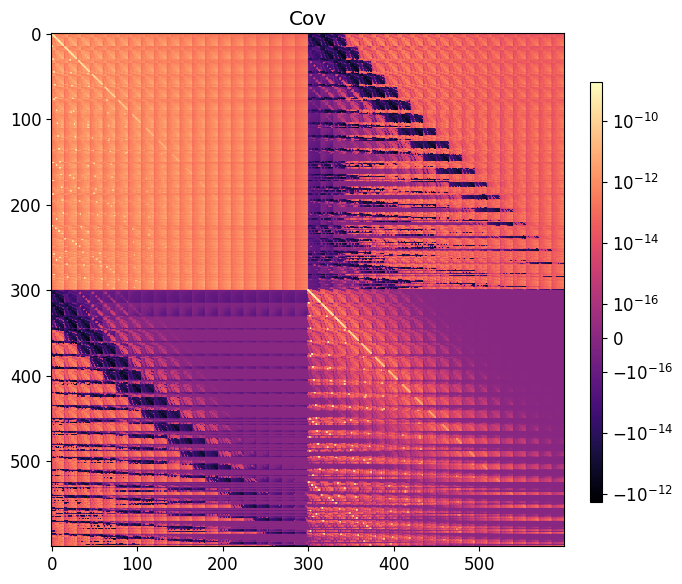

In [60]:
fig, axs = plt.subplots(1, 1, figsize=(6,6))

im = axs.imshow(cov_tot_BNT_order,cmap='magma',norm=matplotlib.colors.SymLogNorm(1e-16))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)
cov_tot_BNT_order.shape